# Clustering of cleaned USPTO using NameRxn from Nextmove software

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [4]:
# read in rxn class data:
with open("../data/raw/orderly_cond_classes.smi", "r") as file:
    lines = file.readlines()

# Split each line and create a list of lists
data = [line.strip().split(" ") for line in lines]

# Create a dataframe
df = pd.DataFrame(data, columns=['Reaction_String', 'Reaction_Class'])

# Read in reaction conditions data
df2 = pd.read_parquet("../data/raw/orderly_condition_train.parquet")
df3 = pd.read_parquet("../data/raw/orderly_condition_test.parquet")

# Merge the two dataframes
df4 = pd.concat([df2, df3])
df[['product_000', 'reactant_000', 'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001', 'agent_002']] = df4[['product_000', 'reactant_000', 'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001', 'agent_002']]

df['Reaction_Class'] = df['Reaction_Class'].replace('0.0', '0.0.0')

# Split the 'Reaction_Class' column
df['super class'] = df['Reaction_Class'].str.split('.').str[0]
df['mid class'] = df['Reaction_Class'].str.split('.').str[0] + '.' + df['Reaction_Class'].str.split('.').str[1]


In [5]:
super_class_dict = {
    "0": "Unassigned",
    "1": "Heteroatom alkylation and arylation",
    "2": "Acylation and related processes",
    "3": "C-C bond formation",
    "4": "Heterocycle formation",
    "5": "Protections",
    "6": "Deprotections",
    "7": "Reductions",
    "8": "Oxidations",
    "9": "Functional group interconversion (FGI)",
    "10": "Functional group addition (FGA)",
    "11": "Resolution",
    "12": "Miscellaneous"
}
super_class_dict = {key: f"{key}. {value}" for key, value in super_class_dict.items()}

In [6]:
mid_class_dict = {
    "0": "Unassigned",
    "0.1": "Failed reaction",
    "0.2": "Compound purchase",
    "1": "Heteroatom alkylation and arylation",
    "1.1": "N-substitution with alkyl-X",
    "1.2": "Reductive amination",
    "1.3": "N-arylation with Ar-X",
    "1.4": "Amide N-alkylation",
    "1.5": "Aniline N-alkylation",
    "1.6": "Heteroaryl N-alkylation",
    "1.7": "O-substitution",
    "1.8": "S-substitution",
    "1.9": "Other heteroatom alkylation/arylation",
    "2": "Acylation and related processes",
    "2.1": "N-acylation to amide",
    "2.2": "N-sulfonylation",
    "2.3": "N-acylation to urea",
    "2.4": "Carbamate/carbonate formation",
    "2.5": "Amidine formation",
    "2.6": "O-acylation to ester",
    "2.7": "O-sulfonylation",
    "2.8": "Other acylation",
    "3": "C-C bond formation",
    "3.1": "Suzuki coupling",
    "3.2": "Heck reaction",
    "3.3": "Sonogashira reaction",
    "3.4": "Stille reaction",
    # "3.5": "Other Pd-catalyzed reactions (Negishi, Kumada, etc.)",
    "3.5": "Other Pd-catalyzed reaction",
    "3.6": "Ester condensation",
    "3.7": "Grignard",
    "3.8": "Wittig olefination",
    # "3.9": "Other organometallic C-C bond formation",
    "3.9": "Other organometallic reaction",
    "3.10": "Friedel-Crafts acylation",
    "3.11": "Other C-C bond formation",
    "4": "Heterocycle formation",
    "4.1": "N-containing heterocycle formation",
    "4.2": "O-containing heterocycle formation",
    "4.3": "S-containing heterocycle formation",
    "4.4": "Other heterocycle forming reactions",
    "5": "Protections",
    "5.1": "NH protections",
    "5.2": "RCO2H protections",
    "5.3": "ROH protections",
    "5.4": "RSH protections",
    "5.5": "Other protections",
    "6": "Deprotections",
    "6.1": "NH deprotections",
    "6.2": "RCO2H deprotections",
    "6.3": "ROH deprotections",
    "6.4": "RSH deprotections",
    "6.5": "Other deprotections",
    "7": "Reductions",
    "7.1": "Nitro to amine reduction",
    "7.2": "Amide to amine reduction",
    "7.3": "Cyano or imine to amine",
    "7.4": "Ester to alcohol",
    "7.5": "Ketone to alcohol",
    "7.6": "Alkene to alkane",
    "7.7": "Alkyne to alkane",
    "7.8": "Aryl/hetaryl to fully saturated",
    "7.9": "Other reductions",
    "8": "Oxidations",
    "8.1": "Alcohols to aldehydes",
    "8.2": "Oxidations at sulphur",
    "8.3": "Alcohols to acids",
    "8.4": "Oxidations at nitrogen",
    "8.5": "Alkene oxidative cleavage",
    "8.6": "Benzylic/allylic oxidation",
    "8.7": "Alkene oxidation",
    "8.8": "Other oxidations",
    "9": "Functional group interconversion (FGI)",
    "9.1": "Alcohol to halide",
    "9.2": "Amide to imidoyl chloride",
    "9.3": "Acid to acid chloride",
    "9.4": "Nitrile to acid",
    "9.5": "Dehydration",
    "9.6": "Carbonyl to C=N",
    "9.7": "Other functional group interconversion",
    "10": "Functional group addition (FGA)",
    "10.1": "Halogenation",
    "10.2": "Nitration",
    "10.3": "Sulfonation",
    "10.4": "Other functional group addition",
    "11": "Resolution",
    "11.1": "Purification",
    "11.2": "Separation",
    "11.3": "Chiral separation",
    "11.4": "Ion exchange",
    "11.5": "Isomerization",
    "11.6": "Purification",
    "11.7": "Racemization",
    "11.8": "Salt formation",
    "11.9": "Separation",
    "12": "Miscellaneous",
    "12.1": "Diazald diazomethane preparation",
    "12.2": "MNNG diazomethane preparation"
}
mid_class_dict = {key: f"{key} {value}" for key, value in mid_class_dict.items()}


In [7]:
len(super_class_dict), len(mid_class_dict), 

(13, 96)

In [8]:
len(set(df['super class'])), len(set(df['mid class'])), len(set(df['Reaction_Class']))

(12, 72, 4106)

In [9]:
df['super class name'] = df['super class'].map(super_class_dict)
df['mid class name'] = df['mid class'].map(mid_class_dict)
df.head()

,Reaction_String,Reaction_Class,product_000,reactant_000,reactant_001,solvent_000,solvent_001,agent_000,agent_001,agent_002,super class,mid class,super class name,mid class name
0,CC(C)(C)OC(=O)[N:14]1[CH2:13][CH2:12][CH:11]([...,6.1.1,Nc1cccc2cnc(Cl)cc12,O=[N+]([O-])c1cccc2cnc(Cl)cc12,NULL,O,CC(=O)O,[Fe],[Na+],[OH-],6,6.1,6. Deprotections,6.1 NH deprotections
1,CN1C(=O)C(Br)=C(C2=C(CCCCC3=Cc4ccccc4N3)Nc3ccc...,0.0.0,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,NULL,CCO,None,Cl,None,None,0,0.0,0. Unassigned,NaN
2,BrC(Br)(Br)Br.O[CH2:1][c:2]1[cH:3][c:4]2[cH:5]...,9.1.5,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21,NULL,CCO,None,Cl,None,None,9,9.1,9. Functional group interconversion (FGI),9.1 Alcohol to halide
3,O=[N+:21]([O-])[c:20]1[cH:19][cH:18][c:17](-[c...,7.1.1,CCSc1ccc2c(c1)C(CC(=O)O)=Cc1ccccc1N2C,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,NULL,CCO,None,[K+],[OH-],Cl,7,7.1,7. Reductions,7.1 Nitro to amine reduction
4,O[CH2:10][CH2:9][NH:8][C:6]([O:5][C:2]([CH3:1]...,1.7.7,Clc1ccc2nc3n(c2c1)CCC3,Cl,Nc1ccc2nc3n(c2c1)CCC3,O,None,O=N[O-],[Na+],None,1,1.7,1. Heteroatom alkylation and arylation,1.7 O-substitution


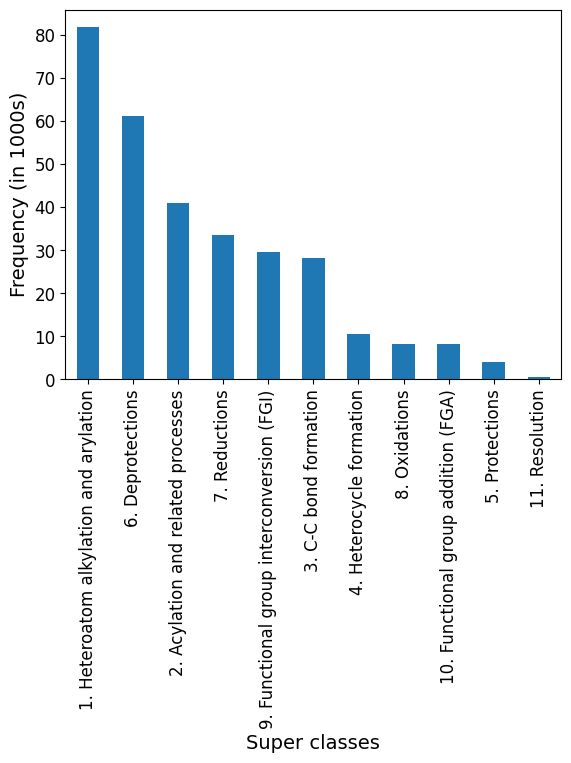

In [33]:
import matplotlib.pyplot as plt

# Plot histogram
df['super class name'].value_counts().plot(kind='bar')

# Updating the title and label sizes
# plt.title('Distribution of super class', fontsize=18)
plt.xlabel('Super classes', fontsize=14)
plt.ylabel('Frequency (in 1000s)', fontsize=14)

# Formatting the y-tick labels to represent values in thousands
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,.0f}'.format(x/1000)))

# Setting the font size of the ticks
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# save
plt.savefig('super_classes.png', dpi=600, bbox_inches='tight')
plt.show()

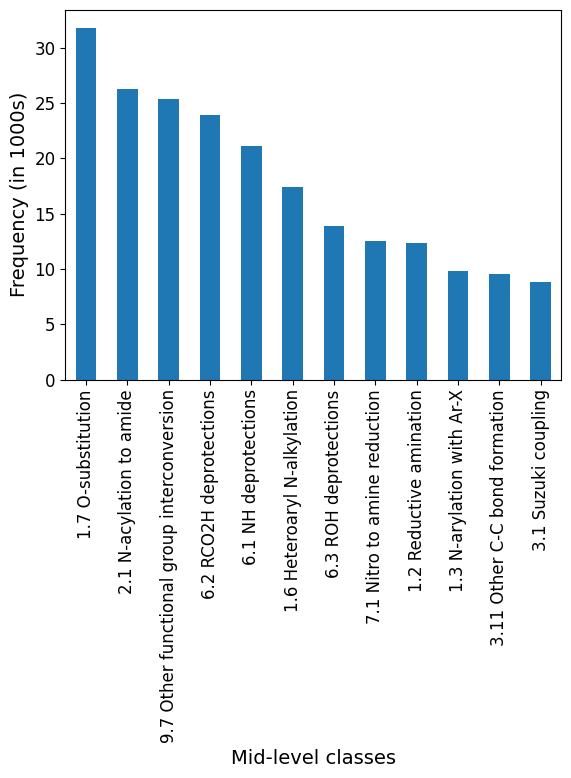

In [32]:
# Plot histogram
df['mid class name'].value_counts()[:12].plot(kind='bar')

# Updating the title and label sizes
# plt.title('Distribution of mid class', fontsize=18)
plt.xlabel('Mid-level classes', fontsize=14)
plt.ylabel('Frequency (in 1000s)', fontsize=14)

# Formatting the y-tick labels to represent values in thousands
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,.0f}'.format(x/1000)))

# Setting the font size of the ticks
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.savefig('mid_classes.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

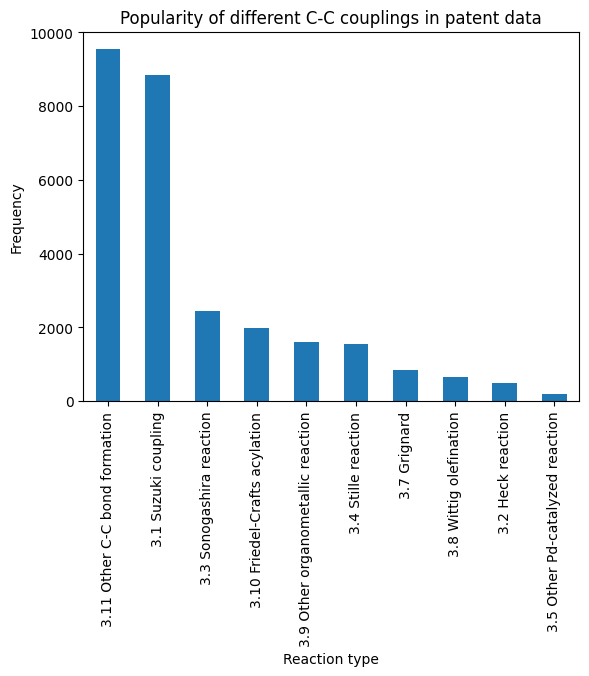

In [12]:
# Plot histogram of C-C couplings
cc_df = df[df['super class']=="3"]


cc_df['mid class name'].value_counts()[:12].plot(kind='bar')
plt.title('Popularity of different C-C couplings in patent data')
plt.xlabel('Reaction type')
plt.ylabel('Frequency')
# increase font size
plt.show()

## Build train test splits based on rxn class

In [13]:
# Remove unassigned reactions
print(len(df))
df = df[df['super class'] != '0']
print(len(df))

356906
306427


In [14]:
super_class_train = df[df['super class'] != '3']
super_class_test = df[df['super class'] == '3']
# save as parquet
super_class_train.to_parquet('../data/super_class_cc_train.parquet')
super_class_test.to_parquet('../data/super_class_cc_test.parquet')

super_class_fgi_train = df[df['super class'] != '9']
super_class_fgi_test = df[df['super class'] == '9']
# save as parquet
super_class_fgi_train.to_parquet('../data/super_class_fgi_train.parquet')
super_class_fgi_test.to_parquet('../data/super_class_fgi_test.parquet')

super_class_reductions_train = df[df['super class'] != '7']
super_class_reductions_test = df[df['super class'] == '7']
# save as parquet
super_class_reductions_train.to_parquet('../data/super_class_reductions_train.parquet')
super_class_reductions_test.to_parquet('../data/super_class_reductions_test.parquet')



In [21]:
super_class_fgi_test.shape

(29514, 14)

In [15]:
# Also do random split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.to_parquet('../data/random_train.parquet')
test.to_parquet('../data/random_test.parquet')

In [16]:
# For subclass split, randomly select one of the mid classes from each super class
# I used google rng to select a random subclass from each
# 1.5
# 2.4
# 3.8
# 4.2
# 5.4
# 6.1
# 7.5
# 8.1
# 9.3
# 10.2
# 11.4
# 12.1
# List of values to filter
values_to_exclude = ['1.5', '2.4', '3.8', '4.2', '5.4', '6.1', '7.5', '8.1', '9.3', '10.2', '11.4', '12.1']

# Create train and test dataframes
mid_class_train = df[~df['mid class'].isin(values_to_exclude)]
mid_class_test = df[df['mid class'].isin(values_to_exclude)]
# save as parquet
mid_class_train.to_parquet('../data/mid_class_train.parquet')
mid_class_test.to_parquet('../data/mid_class_test.parquet')

In [17]:
len(super_class_train), len(super_class_test), len(mid_class_train), len(mid_class_test)

(278240, 28187, 271394, 35033)

In [18]:
(35033)/(35033+271394)

0.11432739282112869

# Add OHE columns to FP data

In [2]:
random_train = pd.read_parquet('../data/random_train.parquet')
random_test = pd.read_parquet('../data/random_test.parquet')

random_train_fp = np.load('../data/fingerprints/random_train.npy')
random_test_fp = np.load('../data/fingerprints/random_test.npy')

In [3]:
# create OHE based on super class
enc = OneHotEncoder(handle_unknown='ignore')
# fit on train data
enc.fit(random_train[['super class']])
# transform train and test data
random_train_ohe = enc.transform(random_train[['super class']])
random_test_ohe = enc.transform(random_test[['super class']])
# convert to array
random_train_ohe = random_train_ohe.toarray()
random_test_ohe = random_test_ohe.toarray()

# add to the random_train_fp and random_test_fp
random_train_fp = np.concatenate((random_train_fp, random_train_ohe), axis=1)
random_test_fp = np.concatenate((random_test_fp, random_test_ohe), axis=1)

# Add a column of zeroes so it's an even number
random_train_fp = np.concatenate((random_train_fp, np.zeros((len(random_train_fp), 1))), axis=1)
random_test_fp = np.concatenate((random_test_fp, np.zeros((len(random_test_fp), 1))), axis=1)

In [5]:
# save as npy
np.save('../data/fingerprints/random_train_fp_ohe.npy', random_train_fp)
np.save('../data/fingerprints/random_test_fp_ohe.npy', random_test_fp)

In [6]:
random_train_fp.shape

(245141, 4108)

# Inspect data